In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

import tensorflow as tf

np.random.seed(222)

In [3]:
import tensorflow as tf
# import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import shutil

from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import TimeDistributed, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import resnet

from sklearn.model_selection import train_test_split
import matplotlib.cm as cm

In [4]:
# import tensorflow as tf
# from tensorflow.keras.datasets import mnist
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten
# from tensorflow.keras.optimizers import Adam
# import numpy as np
# from PIL import Image
# import skimage.io 
# import skimage.segmentation
# import copy
# import sklearn
# import sklearn.metrics
# from sklearn.linear_model import LinearRegression
# import matplotlib.pyplot as plt
# import torch
# import torchvision
# import pandas as pd

## LOAD STAR Decoap Dataset

In [5]:
GLOBAL_SEED = 744
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

In [6]:
src_dir = 'input/Shaver Shell - Print'

root_dir = './'
train_dir = 'shaver_shell_train'
test_dir = 'shaver_shell_test'
class_double_print = '19-01 dubbeldruk'
class_good = '19-01 goed'
class_interrupted = '19-01 onderbroken'
all_classes = [class_double_print, class_good, class_interrupted]

In [7]:
batch_size = 32
img_height = 220
img_width = 360
epochs = 100

## KERAS

In [8]:
import pathlib
data_dir=src_dir
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.png')))

In [9]:
import os

def get_label(file_path):
  # Convert the path to a list of path components
  print(file_path)
  parts = tf.strings.split(file_path, '/')
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  print(file_path)
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [10]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [11]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['19-01 dubbeldruk' '19-01 goed' '19-01 onderbroken']


In [12]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string)


In [14]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(180, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [15]:
# convnet = Sequential() 
# convnet.add(resnet.ResNet50(
#     weights="imagenet", input_shape=(220,360,3), include_top=False
# ))
# convnet.add(Flatten())
# convnet.add(keras.layers.Dense(len(all_classes), activation="softmax", 
#                          kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.0001)))

# model = convnet
# optimizer = Adam(0.00001)
# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [16]:
for image, label in train_ds.take(3):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (220, 360, 3)
Label:  1
Image shape:  (220, 360, 3)
Label:  0
Image shape:  (220, 360, 3)
Label:  1


In [17]:
from pathlib import Path
import imghdr

image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [18]:
x_train=[]
y_train=[]
for image, label in train_ds:
    x_train.append(image.numpy())
    y_train.append(label.numpy())

x_test=[]
y_test=[]
for image, label in val_ds:
    x_test.append(image.numpy())
    y_test.append(label.numpy())

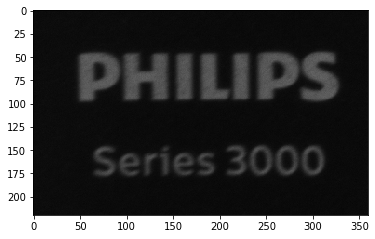

In [19]:
plt.imshow(x_train[0].astype('uint8'))

In [20]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [21]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

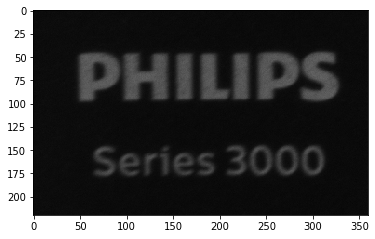

In [22]:
plt.imshow(x_train[0])

In [23]:
len(x_train) , len(x_test)

(2852, 712)

In [24]:
# from keras.utils.np_utils import to_categorical   

# categorical_labels_train = to_categorical(y_train, num_classes=3)
# categorical_labels_test = to_categorical(y_test, num_classes=3)

In [25]:
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 220, 360, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 218, 358, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 179, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 177, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 88, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 51, 86, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 43, 32)        0

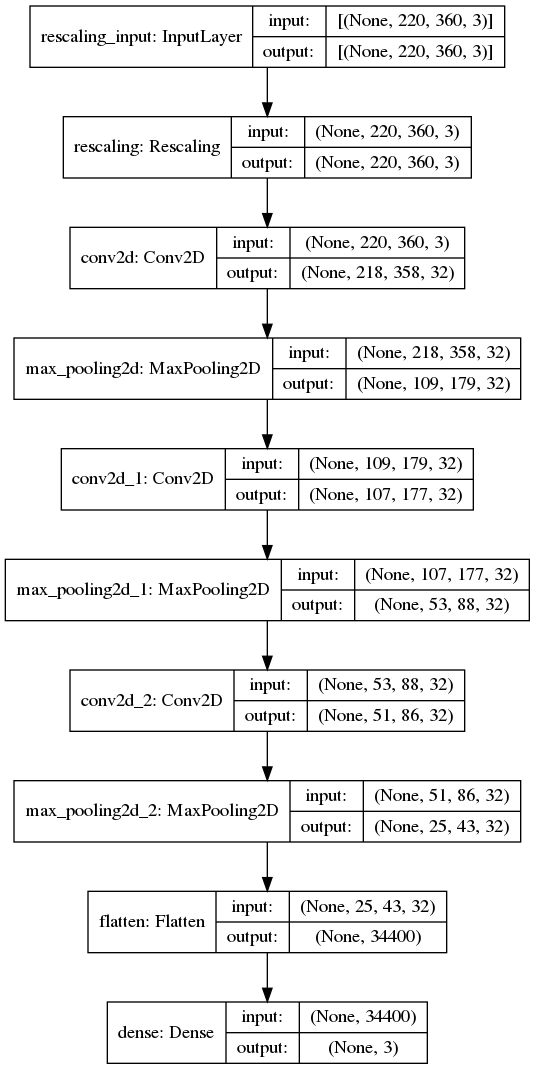

In [26]:
# model = convnet
# optimizer = Adam(0.00001)
# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.build(input_shape=(None,220,360,3))
print(model.summary())
keras.utils.plot_model(model, "my_first_model.png", show_shapes=True)

# model.fit(
#     x_train,
#     y_train,
#     verbose='auto',
#     callbacks=None,
#     validation_split=0.2,
#     epochs=epochs
# )

In [27]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [28]:
import datetime
model_file_name = 'model_normal_data_by_mak'
model_path = os.path.join(root_dir, 'models', model_file_name)

if not(os.path.exists(model_path)):
#     AUTOTUNE = tf.data.AUTOTUNE

    mc = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True, verbose = 1)

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    model.fit(
    x_train,
    y_train,
    verbose=1,
    validation_split=0.2,
    epochs=epochs,
    callbacks=[mc,tensorboard_callback]
)


In [29]:
model = tf.keras.models.load_model(model_path)
model.evaluate(x_test, y_test)

23/23 [==============================] - 2s 89ms/step - loss: 0.1098 - accuracy: 0.9705


[0.10976690798997879, 0.9705055952072144]

In [30]:
y_pred = model.predict(x_test)


import sklearn.metrics as metrics
report = metrics.classification_report(y_test, tf.argmax(input=y_pred, axis=1).numpy())
print(report) 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        46
           1       0.97      0.99      0.98       540
           2       0.95      0.88      0.91       126

    accuracy                           0.97       712
   macro avg       0.97      0.96      0.96       712
weighted avg       0.97      0.97      0.97       712



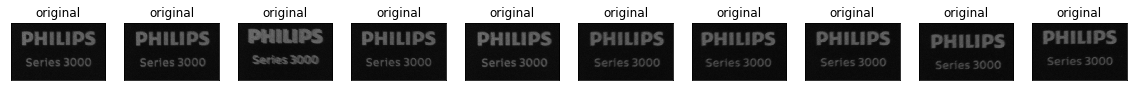

In [31]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

#   # display reconstruction
#   ax = plt.subplot(2, n, i + 1 + n)
#   plt.imshow(decoded_imgs[i])
#   plt.title("reconstructed")
#   plt.gray()
#   ax.get_xaxis().set_visible(False)
#   ax.get_yaxis().set_visible(False)
plt.show()

In [32]:
# from tensorflow.keras.preprocessing import image

# def predict_image(class_label):
#     path = os.path.join(root_dir,  test_dir, class_label)
#     class_files = os.listdir(path)

#     image_file = random.choice(class_files)
#     print('Image file: ' + path + "/" + image_file)

#     test_img = image.load_img(os.path.join(path, image_file), target_size=(220, 360))
#     plt.imshow(test_img, cmap='gray')

#     print("True label: ", class_label)

#     pre_processed_image = np.expand_dims(test_img, axis=0)
#     print(pre_processed_image.shape)
#     pred = model.predict(pre_processed_image)
#     class_name = CLASS_NAMES_LOADED[pred.argmax(axis=-1)[0]]

#     print("Raw Prediction: ", pred)
#     print("Predicted label: ", class_name)

In [33]:
# predict_image(class_good)


In [34]:
# def get_correct_and_predicted_labels():

#     y_pred = []
#     y_true = [] 

#     for image_batch, label_batch in test_ds: 
#         y_true += (np.argmax(label_batch.numpy(), axis = - 1)).tolist()
#         preds = model.predict(image_batch)
#         y_pred += (np.argmax(preds, axis = - 1)).tolist()

#     return (y_true, y_pred)

# correct_labels, predicted_labels = get_correct_and_predicted_labels()


# import sklearn.metrics as metrics
# report = metrics.classification_report(correct_labels, predicted_labels, target_names=CLASS_NAMES_LOADED)
# print(report)  

In [35]:
# from sklearn.metrics import roc_auc_score
# from tqdm.auto import tqdm

# preds = []
# true_labels = []

# for inputs, labels in tqdm(test_ds):
#     logits = model.predict(inputs)
    
#     true_labels += (np.argmax(labels.numpy(), axis = 1)).tolist()
#     preds += logits.tolist()

# roc_auc_score(true_labels, preds, multi_class='ovr', average='weighted')

## LIME

In [36]:
# !pip install lime

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries


In [37]:
# path = os.path.join(root_dir,  test_dir, '19-01 onderbroken')
# class_files = os.listdir(path)

# image_file = random.choice(class_files) ##'./shaver_shell_test/19-01 dubbeldruk/photo_112_carrier_6_left.png' #
# print('Image file: ' + image_file)

# test_img = image.load_img(os.path.join(path, image_file))
# img_array = image.img_to_array(test_img)
# img_array_rs = tf.reshape(img_array, (1, 220, 360, 3))

# explainer = lime_image.LimeImageExplainer(random_state=GLOBAL_SEED)
# explanation = explainer.explain_instance(
#          img_array_rs[0].numpy().astype(np.double), 
#          model.predict,
#          top_labels=3, hide_color=0, num_samples=50
# )

In [38]:
explainer = lime_image.LimeImageExplainer(random_state=GLOBAL_SEED)
explanation = explainer.explain_instance(
         x_test[0].astype(np.double), 
         model.predict,
         top_labels=3, hide_color=0, num_samples=50
)

In [39]:
x_test[0].shape

(220, 360, 3)

In [40]:
im, mask = explanation.get_image_and_mask(
         model.predict(
              x_test
         ).argmax(axis=1)[0],
         positive_only=False, hide_rest=False, num_features = 50)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


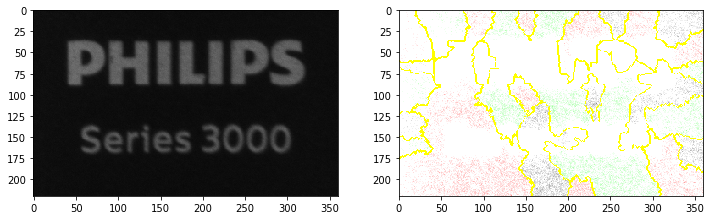

In [41]:
im = mark_boundaries(im, mask)
f, axarr = plt.subplots(1,2, figsize=(12, 12))

axarr[0].imshow(x_test[0])
axarr[1].imshow(im*20)

## Salience Map

In [42]:
!pip install opencv-python

import numpy as np
import cv2

In [43]:
def normalize_image(img):
    grads_norm = img[:,:,0]+ img[:,:,1]+ img[:,:,2]
    grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)- tf.reduce_min(grads_norm))
    return grads_norm
def plot_maps(img1, img2,vmin=0.3,vmax=0.7, mix_val=2):
    f = plt.figure(figsize=(15,45))
    plt.subplot(1,3,1)
    plt.imshow(img1,vmin=vmin, vmax=vmax, cmap="Greens")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(img2, cmap = "Greens")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(img1*mix_val+img2/mix_val, cmap = "Greens" )
    plt.axis("off")

In [44]:
image=x_test[1]

In [45]:
image.shape

(220, 360, 3)

In [46]:
  # Read the image and convert channel order from BGR to RGB
  # YOUR CODE HERE
# img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

  # Resize the image to 300 x 300 and normalize pixel values to the range [0, 1]
  # YOUR CODE HERE
  # img = cv2.resize(img, (360, 220)) / 255.0



  # Add an additional dimension (for the batch), and save this in a new variable
  # YOUR CODE HERE
img = np.expand_dims(image, axis=0)

In [47]:
img.shape

(1, 220, 360, 3)

In [48]:
img = tf.convert_to_tensor(img, dtype=tf.float32)

In [49]:
result = model(img)
max_idx = tf.argmax(result,axis = 1)
print(max_idx)

tf.Tensor([1], shape=(1,), dtype=int64)


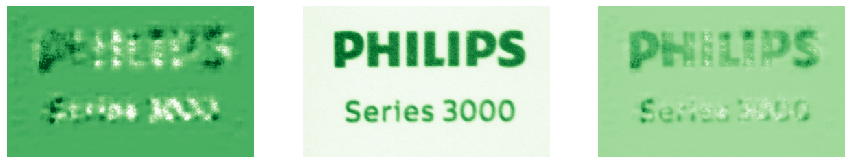

In [50]:
with tf.GradientTape() as tape:
    tape.watch(img)
    result = model(img)
    max_score = result[0,max_idx[0]]
grads = tape.gradient(max_score, img)
plot_maps(normalize_image(grads[0]), normalize_image(img[0]))

(1)Saliency_map (2)Input_image (3)Overlayed_image

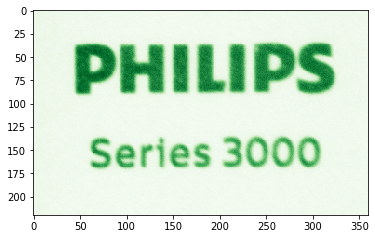

In [51]:
plt.imshow(normalize_image(image), cmap = "Greens" )

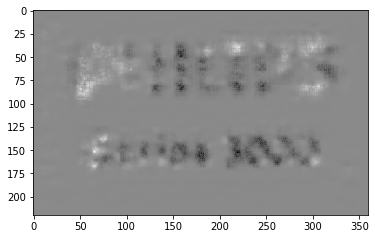

In [66]:
# plt.imshow(normalize_image(grads[0]).numpy())
image_color = cv2.cvtColor(normalize_image(grads[0]).numpy(), cv2.COLOR_GRAY2RGB)
plt.imshow(image_color)
# normalize_image(grads[0])

In [67]:
image_color

array([[[0.5419336 , 0.5419336 , 0.5419336 ],
        [0.541889  , 0.541889  , 0.541889  ],
        [0.54181725, 0.54181725, 0.54181725],
        ...,
        [0.5419336 , 0.5419336 , 0.5419336 ],
        [0.5419336 , 0.5419336 , 0.5419336 ],
        [0.5419336 , 0.5419336 , 0.5419336 ]],

       [[0.5418679 , 0.5418679 , 0.5418679 ],
        [0.54178596, 0.54178596, 0.54178596],
        [0.54166174, 0.54166174, 0.54166174],
        ...,
        [0.5419336 , 0.5419336 , 0.5419336 ],
        [0.5419336 , 0.5419336 , 0.5419336 ],
        [0.5419336 , 0.5419336 , 0.5419336 ]],

       [[0.54187346, 0.54187346, 0.54187346],
        [0.5417862 , 0.5417862 , 0.5417862 ],
        [0.54157096, 0.54157096, 0.54157096],
        ...,
        [0.5419336 , 0.5419336 , 0.5419336 ],
        [0.5419336 , 0.5419336 , 0.5419336 ],
        [0.5419336 , 0.5419336 , 0.5419336 ]],

       ...,

       [[0.5419336 , 0.5419336 , 0.5419336 ],
        [0.5419336 , 0.5419336 , 0.5419336 ],
        [0.5419336 , 0

## Conclusion on Tensorflow 2.x

In this blog, we have defined the saliency map in different aspects. We have added a pictorial representation to understand the term “saliency map” deeply. Also, we have understood it by implementing it in python using TensorFlow API. The results seem promising and can be easily understandable

In [51]:
for layer in model.layers:
    print(layer.name)

rescaling
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
flatten
dense


In [52]:
# for layer in model.get_layer('resnet50').layers:
#     print(layer.name)

In [53]:
layer_name = 'max_pooling2d_2'

## CAM-GRAD

In [54]:
import scipy as sp


# cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].get_output_at(0),model.layers[-1].get_output_at(0)))
cam_model  = Model(inputs=model.input,outputs=(model.get_layer(layer_name).output,model.layers[-2].output))

features,results = cam_model.predict(x_test)

# shape of the features
print("features shape: ", features.shape)
print("results shape", results.shape)

last_dense_layer = model.layers[-1]

# get the weights list.  index 0 contains the weights, index 1 contains the biases
gap_weights_l = last_dense_layer.get_weights()

print("gap_weights_l index 0 contains weights ", gap_weights_l[0].shape)
print("gap_weights_l index 1 contains biases ", gap_weights_l[1].shape)

# shows the number of features per class, and the total number of classes
# Store the weights
gap_weights = gap_weights_l[0]

print(f"There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes.")

# Get the features for the image at index 0
idx = -1
image_index = idx
features_for_img = features[idx,:,:,:]

print(f"The features for image index {idx} has shape (height, width, num of feature channels) : ", features_for_img.shape)

# Select the weights that are used for a specific class (0...9)
class_id = 0
# take the dot product between the scaled image features and the weights for 
gap_weights_for_one_class = gap_weights[:,class_id]
gap_weights_for_one_class = gap_weights_for_one_class.reshape((25, 43, 32))

print("gap_weights_for_one_class has shape ", gap_weights_for_one_class.shape)
# take the dot product between the scaled features and the weights for one class
cam = np.multiply(features_for_img, gap_weights_for_one_class)
cam = sp.ndimage.zoom(cam, (220/25, 360/43, 1), order=2)
cam = np.sum(cam, axis = 2)

print("class activation map shape ", cam.shape)

features shape:  (712, 25, 43, 32)
results shape (712, 34400)
gap_weights_l index 0 contains weights  (34400, 3)
gap_weights_l index 1 contains biases  (3,)
There are 34400 feature weights and 3 classes.
The features for image index -1 has shape (height, width, num of feature channels) :  (25, 43, 32)
gap_weights_for_one_class has shape  (25, 43, 32)
class activation map shape  (220, 360)


11171


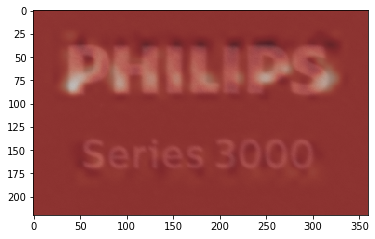

In [55]:
prediction = np.argmax(results[image_index])

# X_test_in = test_ds.unbatch()
# X_test = list(X_test_in.map(lambda x, y: x))

print(prediction)
# show the upsampled image
plt.imshow(x_test[image_index], alpha=0.8)
  
# strongly classified (95% probability) images will be in green, else red
if results[image_index][prediction]>0.95:
    cmap_str = 'Greens'
else:
    cmap_str = 'Reds'

# overlay the cam output
plt.imshow(cam, cmap=cmap_str, alpha=0.5)

# display the image
plt.show()

In [56]:
def show_cam(image_index):
  '''displays the class activation map of a particular image'''

  # takes the features of the chosen image
  features_for_img = features[image_index,:,:,:]

  # get the class with the highest output probability
 

  # get the gap weights at the predicted class
  class_activation_weights = gap_weights[:,prediction]

  # upsample the features to the image's original size (28 x 28)
  class_activation_features = sp.ndimage.zoom(features_for_img, (28/3, 28/3, 1), order=2)

  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)
  
  print('Predicted Class = ' +str(prediction)+ ', Probability = ' + str(results[image_index][prediction]))
  

In [57]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [58]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).get_output_at(0), model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [59]:
from IPython.display import Image, display

def display_gradcam(image, heatmap, alpha=0.4):
    # Load the original image
    img = image*255
#     img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
#     superimposed_img.save(cam_path)

    # Display Grad CAM
    plt.imshow(superimposed_img)


In [60]:
# from IPython.display import Image, display

# def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
#     # Load the original image
#     img = keras.preprocessing.image.load_img(img_path)
#     img = keras.preprocessing.image.img_to_array(img)

#     # Rescale heatmap to a range 0-255
#     heatmap = np.uint8(255 * heatmap)

#     # Use jet colormap to colorize heatmap
#     jet = cm.get_cmap("jet")

#     # Use RGB values of the colormap
#     jet_colors = jet(np.arange(256))[:, :3]
#     jet_heatmap = jet_colors[heatmap]

#     # Create an image with RGB colorized heatmap
#     jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
#     jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
#     jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

#     # Superimpose the heatmap on original image
#     superimposed_img = jet_heatmap * alpha + img
#     superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

#     # Save the superimposed image
#     superimposed_img.save(cam_path)

#     # Display Grad CAM
#     display(Image(cam_path))



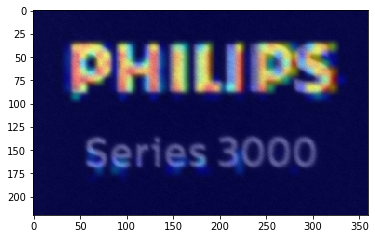

In [61]:
heatmap = make_gradcam_heatmap(img, model, layer_name)
display_gradcam(image, heatmap)

In [62]:
# model.get_layer(layer_name)

In [63]:
from tensorflow.keras.models import Model



def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).get_output_at(0), model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .7
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb
#     return superimposed_img

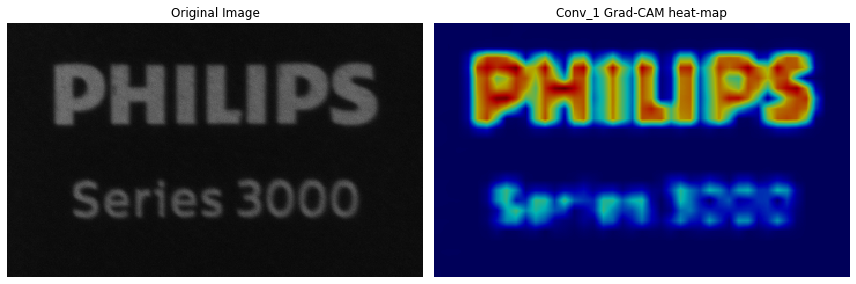

In [64]:
## Grad-CAM heatmap for the last convolutional layer in the model, Conv_1

grad_cam=GradCam(model,np.expand_dims(image, axis=0),layer_name)
grad_cam_superimposed = superimpose(image, grad_cam, 0.5, emphasize=False)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_1 Grad-CAM heat-map')
plt.tight_layout()




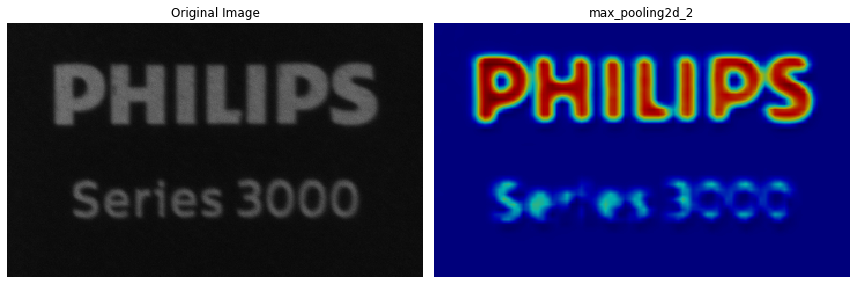

In [65]:
## Grad-CAM heatmap for the block_4_expand_relu
## This layer shows how the model begins learning concepts in the image
grad_cam = GradCam(model, np.expand_dims(image, axis=0), 'conv2d_2')
grad_cam_emphasized = superimpose(image, grad_cam, 0.5, emphasize=False)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_emphasized)
plt.axis('off')
plt.title(layer_name)
plt.tight_layout()


In [66]:
## Gather all convolution and activation layers from the model
## With these layers, we can explore grad-cam heatmaps for more layers in the model

conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
activation_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and layer.__class__.__name__ == 'ReLU']
all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and (layer.__class__.__name__ == 'ReLU' or isinstance(layer, tf.keras.layers.Conv2D))]


In [67]:
conv2D_layers

['conv2d_2', 'conv2d_1', 'conv2d']

In [68]:
## Visualizing Activation layers
plt.figure(figsize=(15, 15))
for i, layer in enumerate(activation_layers):
    print(layer.name)
    grad_cam = GradCam(model, np.expand_dims(image, axis=0), layer)
    grad_cam_emphasized = superimpose(image, grad_cam, 0.5, emphasize=False)
    ax = plt.subplot(7, 5, i +1)
    plt.imshow(grad_cam_emphasized)
    plt.title(layer)
    plt.axis("off")
plt.tight_layout()

<Figure size 1080x1080 with 0 Axes>

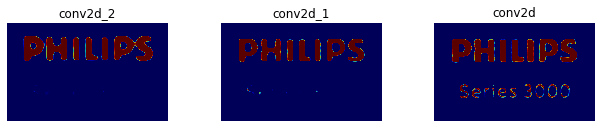

In [69]:
## Visualizing Convolution layers
plt.figure(figsize=(12, 20))
for i, layer in enumerate(conv2D_layers):
  grad_cam = GradCam(model, np.expand_dims(image, axis=0), layer)
  grad_cam_emphasized = superimpose(image, grad_cam, 0.5, emphasize=True)
  ax = plt.subplot(13, 4, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()


In [117]:
img.shape

TensorShape([1, 220, 360, 3])

In [118]:
from IPython.display import Image, display

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.7):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    # isplay(Image(cam_path))



In [119]:
all_classes

['19-01 dubbeldruk', '19-01 goed', '19-01 onderbroken']

In [120]:
for i, currentCls in enumerate(all_classes):
  
    src = src_dir + '/' + currentCls

    allFileNames = os.listdir(src)
    for image_file in allFileNames:
        
        #image_file = random.choice(allFileNames)
        print(src+'/'+ image_file)
    
        img_array = get_img_array(src+'/'+ image_file, size = (220,360,3))
        img_array=img_array/255
        heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_14')
    
    # print(img_array)
    
        save_and_display_gradcam(src+'/'+ image_file, heatmap, cam_path='input/gradcam/Shaver Shell - Print/'+currentCls+'/'+image_file)

input/Shaver Shell - Print/19-01 dubbeldruk/photo_112_carrier_6_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_96_carrier_2_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_31_carrier_10_right.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_121_carrier_3_right.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_68_carrier_11_right.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_109_carrier_3_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_33_carrier_12_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_2_carrier_5_right.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_1_carrier_4_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_37_carrier_4_right.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_113_carrier_7_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_37_carrier_4_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_67_carrier_10_right.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_31

input/Shaver Shell - Print/19-01 dubbeldruk/photo_85_carrier_3_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_79_carrier_10_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_30_carrier_9_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_87_carrier_5_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_57_carrier_12_right.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_52_carrier_7_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_0_carrier_3_right.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_120_carrier_2_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_4_carrier_7_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_13_carrier_4_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_118_carrier_12_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_22_carrier_1_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_18_carrier_9_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_8_carrier

input/Shaver Shell - Print/19-01 dubbeldruk/photo_101_carrier_7_right.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_30_carrier_9_right.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_28_carrier_7_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_71_carrier_2_right.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_73_carrier_4_right.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_10_carrier_1_right.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_100_carrier_6_right.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_108_carrier_2_right.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_91_carrier_9_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_105_carrier_11_left.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_50_carrier_5_right.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_4_carrier_7_right.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_97_carrier_3_right.png
input/Shaver Shell - Print/19-01 dubbeldruk/photo_

input/Shaver Shell - Print/19-01 goed/photo_1352_carrier_2_left.png
input/Shaver Shell - Print/19-01 goed/photo_40_carrier_3_left.png
input/Shaver Shell - Print/19-01 goed/photo_128_carrier_7_left.png
input/Shaver Shell - Print/19-01 goed/photo_1202_carrier_9_right.png
input/Shaver Shell - Print/19-01 goed/photo_1029_carrier_7_left.png
input/Shaver Shell - Print/19-01 goed/photo_900_carrier_12_left.png
input/Shaver Shell - Print/19-01 goed/photo_641_carrier_11_left.png
input/Shaver Shell - Print/19-01 goed/photo_670_carrier_3_right.png
input/Shaver Shell - Print/19-01 goed/photo_584_carrier_2_right.png
input/Shaver Shell - Print/19-01 goed/photo_339_carrier_11_right.png
input/Shaver Shell - Print/19-01 goed/photo_470_carrier_9_right.png
input/Shaver Shell - Print/19-01 goed/photo_850_carrier_12_left.png
input/Shaver Shell - Print/19-01 goed/photo_710_carrier_6_left.png
input/Shaver Shell - Print/19-01 goed/photo_201_carrier_7_right.png
input/Shaver Shell - Print/19-01 goed/photo_747_ca

input/Shaver Shell - Print/19-01 goed/photo_156_carrier_10_right.png
input/Shaver Shell - Print/19-01 goed/photo_885_carrier_9_right.png
input/Shaver Shell - Print/19-01 goed/photo_1146_carrier_2_left.png
input/Shaver Shell - Print/19-01 goed/photo_1180_carrier_11_right.png
input/Shaver Shell - Print/19-01 goed/photo_1337_carrier_12_left.png
input/Shaver Shell - Print/19-01 goed/photo_523_carrier_1_left.png
input/Shaver Shell - Print/19-01 goed/photo_1137_carrier_5_left.png
input/Shaver Shell - Print/19-01 goed/photo_1304_carrier_3_left.png
input/Shaver Shell - Print/19-01 goed/photo_719_carrier_3_right.png
input/Shaver Shell - Print/19-01 goed/photo_1254_carrier_1_left.png
input/Shaver Shell - Print/19-01 goed/photo_121_carrier_12_left.png
input/Shaver Shell - Print/19-01 goed/photo_424_carrier_11_left.png
input/Shaver Shell - Print/19-01 goed/photo_1313_carrier_12_right.png
input/Shaver Shell - Print/19-01 goed/photo_267_carrier_12_right.png
input/Shaver Shell - Print/19-01 goed/phot

input/Shaver Shell - Print/19-01 goed/photo_839_carrier_1_left.png
input/Shaver Shell - Print/19-01 goed/photo_1086_carrier_4_right.png
input/Shaver Shell - Print/19-01 goed/photo_1265_carrier_12_right.png
input/Shaver Shell - Print/19-01 goed/photo_422_carrier_9_left.png
input/Shaver Shell - Print/19-01 goed/photo_1251_carrier_10_left.png
input/Shaver Shell - Print/19-01 goed/photo_1203_carrier_10_right.png
input/Shaver Shell - Print/19-01 goed/photo_1206_carrier_1_left.png
input/Shaver Shell - Print/19-01 goed/photo_1061_carrier_3_right.png
input/Shaver Shell - Print/19-01 goed/photo_449_carrier_12_left.png
input/Shaver Shell - Print/19-01 goed/photo_1328_carrier_3_left.png
input/Shaver Shell - Print/19-01 goed/photo_1239_carrier_10_left.png
input/Shaver Shell - Print/19-01 goed/photo_659_carrier_5_right.png
input/Shaver Shell - Print/19-01 goed/photo_274_carrier_7_left.png
input/Shaver Shell - Print/19-01 goed/photo_546_carrier_12_right.png
input/Shaver Shell - Print/19-01 goed/phot

input/Shaver Shell - Print/19-01 goed/photo_442_carrier_5_left.png
input/Shaver Shell - Print/19-01 goed/photo_681_carrier_2_left.png
input/Shaver Shell - Print/19-01 goed/photo_1283_carrier_6_left.png
input/Shaver Shell - Print/19-01 goed/photo_1022_carrier_12_left.png
input/Shaver Shell - Print/19-01 goed/photo_533_carrier_11_right.png
input/Shaver Shell - Print/19-01 goed/photo_680_carrier_1_left.png
input/Shaver Shell - Print/19-01 goed/photo_1108_carrier_1_left.png
input/Shaver Shell - Print/19-01 goed/photo_1070_carrier_12_right.png
input/Shaver Shell - Print/19-01 goed/photo_819_carrier_5_right.png
input/Shaver Shell - Print/19-01 goed/photo_0_carrier_1_left.png
input/Shaver Shell - Print/19-01 goed/photo_106_carrier_9_right.png
input/Shaver Shell - Print/19-01 goed/photo_213_carrier_6_left.png
input/Shaver Shell - Print/19-01 goed/photo_307_carrier_4_right.png
input/Shaver Shell - Print/19-01 goed/photo_1331_carrier_6_left.png
input/Shaver Shell - Print/19-01 goed/photo_1103_ca

input/Shaver Shell - Print/19-01 goed/photo_334_carrier_6_right.png
input/Shaver Shell - Print/19-01 goed/photo_645_carrier_3_left.png
input/Shaver Shell - Print/19-01 goed/photo_1027_carrier_5_left.png
input/Shaver Shell - Print/19-01 goed/photo_1350_carrier_12_right.png
input/Shaver Shell - Print/19-01 goed/photo_607_carrier_1_right.png
input/Shaver Shell - Print/19-01 goed/photo_120_carrier_11_right.png
input/Shaver Shell - Print/19-01 goed/photo_718_carrier_2_left.png
input/Shaver Shell - Print/19-01 goed/photo_1271_carrier_6_right.png
input/Shaver Shell - Print/19-01 goed/photo_102_carrier_5_left.png
input/Shaver Shell - Print/19-01 goed/photo_744_carrier_4_right.png
input/Shaver Shell - Print/19-01 goed/photo_268_carrier_1_right.png
input/Shaver Shell - Print/19-01 goed/photo_938_carrier_1_left.png
input/Shaver Shell - Print/19-01 goed/photo_1078_carrier__left.png
input/Shaver Shell - Print/19-01 goed/photo_856_carrier_5_right.png
input/Shaver Shell - Print/19-01 goed/photo_872_c

input/Shaver Shell - Print/19-01 goed/photo_147_carrier_1_left.png
input/Shaver Shell - Print/19-01 goed/photo_871_carrier__left.png
input/Shaver Shell - Print/19-01 goed/photo_615_carrier_9_left.png
input/Shaver Shell - Print/19-01 goed/photo_1008_carrier_10_left.png
input/Shaver Shell - Print/19-01 goed/photo_501_carrier_3_right.png
input/Shaver Shell - Print/19-01 goed/photo_1232_carrier_3_left.png
input/Shaver Shell - Print/19-01 goed/photo_460_carrier_11_left.png
input/Shaver Shell - Print/19-01 goed/photo_1352_carrier_2_right.png
input/Shaver Shell - Print/19-01 goed/photo_1266_carrier_1_left.png
input/Shaver Shell - Print/19-01 goed/photo_1036_carrier_2_right.png
input/Shaver Shell - Print/19-01 goed/photo_98_carrier_1_left.png
input/Shaver Shell - Print/19-01 goed/photo_434_carrier_9_left.png
input/Shaver Shell - Print/19-01 goed/photo_1292_carrier_3_left.png
input/Shaver Shell - Print/19-01 goed/photo_360_carrier__right.png
input/Shaver Shell - Print/19-01 goed/photo_521_carri

input/Shaver Shell - Print/19-01 goed/photo_1300_carrier_11_left.png
input/Shaver Shell - Print/19-01 goed/photo_573_carrier_3_left.png
input/Shaver Shell - Print/19-01 goed/photo_477_carrier_4_right.png
input/Shaver Shell - Print/19-01 goed/photo_206_carrier_11_left.png
input/Shaver Shell - Print/19-01 goed/photo_897_carrier_9_left.png
input/Shaver Shell - Print/19-01 goed/photo_813_carrier_11_right.png
input/Shaver Shell - Print/19-01 goed/photo_685_carrier_6_right.png
input/Shaver Shell - Print/19-01 goed/photo_1198_carrier_5_left.png
input/Shaver Shell - Print/19-01 goed/photo_788_carrier_11_left.png
input/Shaver Shell - Print/19-01 goed/photo_369_carrier_5_left.png
input/Shaver Shell - Print/19-01 goed/photo_956_carrier_6_left.png
input/Shaver Shell - Print/19-01 goed/photo_11_carrier_11_right.png
input/Shaver Shell - Print/19-01 goed/photo_367_carrier_3_right.png
input/Shaver Shell - Print/19-01 goed/photo_345_carrier_5_right.png
input/Shaver Shell - Print/19-01 goed/photo_423_ca

input/Shaver Shell - Print/19-01 goed/photo_43_carrier_6_left.png
input/Shaver Shell - Print/19-01 goed/photo_864_carrier_1_right.png
input/Shaver Shell - Print/19-01 goed/photo_529_carrier_7_left.png
input/Shaver Shell - Print/19-01 goed/photo_243_carrier_12_left.png
input/Shaver Shell - Print/19-01 goed/photo_1272_carrier_7_left.png
input/Shaver Shell - Print/19-01 goed/photo_1087_carrier_5_right.png
input/Shaver Shell - Print/19-01 goed/photo_740_carrier_12_left.png
input/Shaver Shell - Print/19-01 goed/photo_599_carrier_5_right.png
input/Shaver Shell - Print/19-01 goed/photo_1111_carrier_4_left.png
input/Shaver Shell - Print/19-01 goed/photo_1356_carrier_6_right.png
input/Shaver Shell - Print/19-01 goed/photo_689_carrier_10_right.png
input/Shaver Shell - Print/19-01 goed/photo_1254_carrier_1_right.png
input/Shaver Shell - Print/19-01 goed/photo_1050_carrier_4_right.png
input/Shaver Shell - Print/19-01 goed/photo_1042_carrier__left.png
input/Shaver Shell - Print/19-01 goed/photo_682

input/Shaver Shell - Print/19-01 goed/photo_858_carrier_7_left.png
input/Shaver Shell - Print/19-01 goed/photo_324_carrier_8_left.png
input/Shaver Shell - Print/19-01 goed/photo_1176_carrier_7_right.png
input/Shaver Shell - Print/19-01 goed/photo_874_carrier_11_right.png
input/Shaver Shell - Print/19-01 goed/photo_113_carrier_4_left.png
input/Shaver Shell - Print/19-01 goed/photo_393_carrier_5_left.png
input/Shaver Shell - Print/19-01 goed/photo_1318_carrier_5_left.png
input/Shaver Shell - Print/19-01 goed/photo_737_carrier_9_left.png
input/Shaver Shell - Print/19-01 goed/photo_141_carrier_7_right.png
input/Shaver Shell - Print/19-01 goed/photo_557_carrier_11_left.png
input/Shaver Shell - Print/19-01 goed/photo_1148_carrier_3_right.png
input/Shaver Shell - Print/19-01 goed/photo_12_carrier_12_right.png
input/Shaver Shell - Print/19-01 goed/photo_697_carrier_6_right.png
input/Shaver Shell - Print/19-01 goed/photo_1243_carrier_2_right.png
input/Shaver Shell - Print/19-01 goed/photo_1293_

input/Shaver Shell - Print/19-01 goed/photo_895_carrier_7_left.png
input/Shaver Shell - Print/19-01 goed/photo_674_carrier_7_right.png
input/Shaver Shell - Print/19-01 goed/photo_1103_carrier_9_right.png
input/Shaver Shell - Print/19-01 goed/photo_1182_carrier_1_right.png
input/Shaver Shell - Print/19-01 goed/photo_425_carrier_12_left.png
input/Shaver Shell - Print/19-01 goed/photo_547_carrier_1_left.png
input/Shaver Shell - Print/19-01 goed/photo_350_carrier_10_right.png
input/Shaver Shell - Print/19-01 goed/photo_377_carrier_1_right.png
input/Shaver Shell - Print/19-01 goed/photo_811_carrier_10_right.png
input/Shaver Shell - Print/19-01 goed/photo_971_carrier_9_right.png
input/Shaver Shell - Print/19-01 goed/photo_943_carrier_6_right.png
input/Shaver Shell - Print/19-01 goed/photo_626_carrier_8_right.png
input/Shaver Shell - Print/19-01 goed/photo_833_carrier_7_right.png
input/Shaver Shell - Print/19-01 goed/photo_264_carrier_9_left.png
input/Shaver Shell - Print/19-01 goed/photo_684

input/Shaver Shell - Print/19-01 goed/photo_97_carrier_12_left.png
input/Shaver Shell - Print/19-01 goed/photo_728_carrier_12_right.png
input/Shaver Shell - Print/19-01 goed/photo_144_carrier_10_left.png
input/Shaver Shell - Print/19-01 goed/photo_145_carrier_11_left.png
input/Shaver Shell - Print/19-01 goed/photo_826_carrier_12_right.png
input/Shaver Shell - Print/19-01 goed/photo_1074_carrier_4_right.png
input/Shaver Shell - Print/19-01 goed/photo_748_carrier__left.png
input/Shaver Shell - Print/19-01 goed/photo_1336_carrier_11_left.png
input/Shaver Shell - Print/19-01 goed/photo_169_carrier_11_right.png
input/Shaver Shell - Print/19-01 goed/photo_1092_carrier_10_right.png
input/Shaver Shell - Print/19-01 goed/photo_835_carrier_9_left.png
input/Shaver Shell - Print/19-01 goed/photo_857_carrier_6_left.png
input/Shaver Shell - Print/19-01 goed/photo_354_carrier_2_right.png
input/Shaver Shell - Print/19-01 goed/photo_88_carrier_3_right.png
input/Shaver Shell - Print/19-01 goed/photo_543

input/Shaver Shell - Print/19-01 goed/photo_545_carrier_11_right.png
input/Shaver Shell - Print/19-01 goed/photo_669_carrier_2_right.png
input/Shaver Shell - Print/19-01 goed/photo_1067_carrier_9_right.png
input/Shaver Shell - Print/19-01 goed/photo_419_carrier_6_right.png
input/Shaver Shell - Print/19-01 goed/photo_939_carrier_2_left.png
input/Shaver Shell - Print/19-01 goed/photo_830_carrier_4_right.png
input/Shaver Shell - Print/19-01 goed/photo_327_carrier_11_right.png
input/Shaver Shell - Print/19-01 goed/photo_555_carrier_9_left.png
input/Shaver Shell - Print/19-01 goed/photo_762_carrier_10_right.png
input/Shaver Shell - Print/19-01 goed/photo_505_carrier_7_left.png
input/Shaver Shell - Print/19-01 goed/photo_385_carrier_9_right.png
input/Shaver Shell - Print/19-01 goed/photo_1342_carrier_5_right.png
input/Shaver Shell - Print/19-01 goed/photo_703_carrier_12_right.png
input/Shaver Shell - Print/19-01 goed/photo_1054_carrier__left.png
input/Shaver Shell - Print/19-01 goed/photo_39

input/Shaver Shell - Print/19-01 goed/photo_1058_carrier_12_left.png
input/Shaver Shell - Print/19-01 goed/photo_1109_carrier_2_left.png
input/Shaver Shell - Print/19-01 goed/photo_785_carrier__right.png
input/Shaver Shell - Print/19-01 goed/photo_530_carrier__right.png
input/Shaver Shell - Print/19-01 goed/photo_1089_carrier_7_right.png
input/Shaver Shell - Print/19-01 goed/photo_1002_carrier_4_left.png
input/Shaver Shell - Print/19-01 goed/photo_270_carrier_3_right.png
input/Shaver Shell - Print/19-01 goed/photo_25_carrier_12_right.png
input/Shaver Shell - Print/19-01 goed/photo_642_carrier_12_left.png
input/Shaver Shell - Print/19-01 goed/photo_1296_carrier_7_right.png
input/Shaver Shell - Print/19-01 goed/photo_397_carrier_9_right.png
input/Shaver Shell - Print/19-01 goed/photo_1015_carrier_5_right.png
input/Shaver Shell - Print/19-01 goed/photo_288_carrier_9_left.png
input/Shaver Shell - Print/19-01 goed/photo_1219_carrier_2_right.png
input/Shaver Shell - Print/19-01 goed/photo_77

input/Shaver Shell - Print/19-01 goed/photo_1115_carrier__left.png
input/Shaver Shell - Print/19-01 goed/photo_772_carrier_7_right.png
input/Shaver Shell - Print/19-01 goed/photo_523_carrier_1_right.png
input/Shaver Shell - Print/19-01 goed/photo_668_carrier_1_left.png
input/Shaver Shell - Print/19-01 goed/photo_322_carrier_6_right.png
input/Shaver Shell - Print/19-01 goed/photo_1256_carrier_3_right.png
input/Shaver Shell - Print/19-01 goed/photo_437_carrier_12_right.png
input/Shaver Shell - Print/19-01 goed/photo_1205_carrier_12_right.png
input/Shaver Shell - Print/19-01 goed/photo_324_carrier_8_right.png
input/Shaver Shell - Print/19-01 goed/photo_936_carrier_11_left.png
input/Shaver Shell - Print/19-01 goed/photo_736_carrier__left.png
input/Shaver Shell - Print/19-01 goed/photo_892_carrier_4_left.png
input/Shaver Shell - Print/19-01 goed/photo_313_carrier_10_left.png
input/Shaver Shell - Print/19-01 goed/photo_1108_carrier_1_right.png
input/Shaver Shell - Print/19-01 goed/photo_1305

input/Shaver Shell - Print/19-01 goed/photo_52_carrier_3_left.png
input/Shaver Shell - Print/19-01 goed/photo_94_carrier_9_left.png
input/Shaver Shell - Print/19-01 goed/photo_946_carrier_8_right.png
input/Shaver Shell - Print/19-01 goed/photo_527_carrier_5_right.png
input/Shaver Shell - Print/19-01 goed/photo_799_carrier_10_right.png
input/Shaver Shell - Print/19-01 goed/photo_891_carrier_3_right.png
input/Shaver Shell - Print/19-01 goed/photo_830_carrier_4_left.png
input/Shaver Shell - Print/19-01 goed/photo_531_carrier_9_left.png
input/Shaver Shell - Print/19-01 goed/photo_136_carrier_3_left.png
input/Shaver Shell - Print/19-01 goed/photo_1204_carrier_11_left.png
input/Shaver Shell - Print/19-01 goed/photo_810_carrier_9_right.png
input/Shaver Shell - Print/19-01 goed/photo_307_carrier_4_left.png
input/Shaver Shell - Print/19-01 goed/photo_286_carrier_7_left.png
input/Shaver Shell - Print/19-01 goed/photo_1329_carrier_4_left.png
input/Shaver Shell - Print/19-01 goed/photo_559_carrier

input/Shaver Shell - Print/19-01 goed/photo_117_carrier_8_right.png
input/Shaver Shell - Print/19-01 goed/photo_655_carrier_1_right.png
input/Shaver Shell - Print/19-01 goed/photo_1228_carrier_11_left.png
input/Shaver Shell - Print/19-01 goed/photo_514_carrier_4_right.png
input/Shaver Shell - Print/19-01 goed/photo_723_carrier_7_left.png
input/Shaver Shell - Print/19-01 goed/photo_347_carrier_7_left.png
input/Shaver Shell - Print/19-01 goed/photo_1009_carrier_11_right.png
input/Shaver Shell - Print/19-01 goed/photo_451_carrier_2_left.png
input/Shaver Shell - Print/19-01 goed/photo_623_carrier_5_right.png
input/Shaver Shell - Print/19-01 goed/photo_591_carrier_9_right.png
input/Shaver Shell - Print/19-01 goed/photo_135_carrier_2_left.png
input/Shaver Shell - Print/19-01 goed/photo_899_carrier_11_right.png
input/Shaver Shell - Print/19-01 goed/photo_1233_carrier_4_right.png
input/Shaver Shell - Print/19-01 goed/photo_262_carrier_7_right.png
input/Shaver Shell - Print/19-01 goed/photo_708

input/Shaver Shell - Print/19-01 goed/photo_955_carrier_5_left.png
input/Shaver Shell - Print/19-01 goed/photo_48_carrier_11_right.png
input/Shaver Shell - Print/19-01 goed/photo_636_carrier_6_right.png
input/Shaver Shell - Print/19-01 goed/photo_498_carrier_12_right.png
input/Shaver Shell - Print/19-01 goed/photo_1209_carrier_4_left.png
input/Shaver Shell - Print/19-01 goed/photo_223_carrier_4_right.png
input/Shaver Shell - Print/19-01 goed/photo_93_carrier_8_left.png
input/Shaver Shell - Print/19-01 goed/photo_573_carrier_3_right.png
input/Shaver Shell - Print/19-01 goed/photo_999_carrier_1_right.png
input/Shaver Shell - Print/19-01 goed/photo_1358_carrier_8_left.png
input/Shaver Shell - Print/19-01 goed/photo_597_carrier_3_left.png
input/Shaver Shell - Print/19-01 goed/photo_774_carrier_9_right.png
input/Shaver Shell - Print/19-01 goed/photo_1112_carrier_5_left.png
input/Shaver Shell - Print/19-01 goed/photo_671_carrier_4_left.png
input/Shaver Shell - Print/19-01 goed/photo_99_carri

input/Shaver Shell - Print/19-01 goed/photo_667_carrier_12_right.png
input/Shaver Shell - Print/19-01 goed/photo_513_carrier_3_right.png
input/Shaver Shell - Print/19-01 goed/photo_445_carrier_8_left.png
input/Shaver Shell - Print/19-01 goed/photo_596_carrier_2_left.png
input/Shaver Shell - Print/19-01 goed/photo_30_carrier_5_left.png
input/Shaver Shell - Print/19-01 goed/photo_161_carrier_3_right.png
input/Shaver Shell - Print/19-01 goed/photo_1031_carrier_9_right.png
input/Shaver Shell - Print/19-01 goed/photo_110_carrier_1_right.png
input/Shaver Shell - Print/19-01 goed/photo_1303_carrier_2_right.png
input/Shaver Shell - Print/19-01 goed/photo_482_carrier_9_left.png
input/Shaver Shell - Print/19-01 goed/photo_467_carrier_6_right.png
input/Shaver Shell - Print/19-01 goed/photo_577_carrier_7_left.png
input/Shaver Shell - Print/19-01 goed/photo_542_carrier_8_left.png
input/Shaver Shell - Print/19-01 goed/photo_208_carrier_1_right.png
input/Shaver Shell - Print/19-01 goed/photo_27_carri

input/Shaver Shell - Print/19-01 goed/photo_1349_carrier_11_right.png
input/Shaver Shell - Print/19-01 goed/photo_420_carrier_7_right.png
input/Shaver Shell - Print/19-01 goed/photo_243_carrier_12_right.png
input/Shaver Shell - Print/19-01 goed/photo_937_carrier_12_right.png
input/Shaver Shell - Print/19-01 goed/photo_1237_carrier__right.png
input/Shaver Shell - Print/19-01 goed/photo_1252_carrier_11_right.png
input/Shaver Shell - Print/19-01 goed/photo_18_carrier_5_right.png
input/Shaver Shell - Print/19-01 goed/photo_203_carrier_8_right.png
input/Shaver Shell - Print/19-01 goed/photo_155_carrier_9_right.png
input/Shaver Shell - Print/19-01 goed/photo_698_carrier_7_left.png
input/Shaver Shell - Print/19-01 goed/photo_1051_carrier_5_left.png
input/Shaver Shell - Print/19-01 goed/photo_942_carrier_5_left.png
input/Shaver Shell - Print/19-01 goed/photo_1132_carrier_12_left.png
input/Shaver Shell - Print/19-01 goed/photo_600_carrier_6_left.png
input/Shaver Shell - Print/19-01 goed/photo_1

input/Shaver Shell - Print/19-01 goed/photo_1011_carrier_1_left.png
input/Shaver Shell - Print/19-01 goed/photo_38_carrier_1_left.png
input/Shaver Shell - Print/19-01 goed/photo_706_carrier_3_right.png
input/Shaver Shell - Print/19-01 goed/photo_289_carrier_10_left.png
input/Shaver Shell - Print/19-01 goed/photo_316_carrier_12_left.png
input/Shaver Shell - Print/19-01 goed/photo_355_carrier_3_right.png
input/Shaver Shell - Print/19-01 goed/photo_365_carrier_1_left.png
input/Shaver Shell - Print/19-01 goed/photo_1133_carrier_1_right.png
input/Shaver Shell - Print/19-01 goed/photo_761_carrier_9_right.png
input/Shaver Shell - Print/19-01 goed/photo_455_carrier_6_left.png
input/Shaver Shell - Print/19-01 goed/photo_1186_carrier_5_left.png
input/Shaver Shell - Print/19-01 goed/photo_691_carrier_12_left.png
input/Shaver Shell - Print/19-01 goed/photo_1091_carrier_9_left.png
input/Shaver Shell - Print/19-01 goed/photo_131_carrier_10_left.png
input/Shaver Shell - Print/19-01 goed/photo_262_car

input/Shaver Shell - Print/19-01 goed/photo_894_carrier_6_left.png
input/Shaver Shell - Print/19-01 goed/photo_640_carrier_10_right.png
input/Shaver Shell - Print/19-01 goed/photo_275_carrier__left.png
input/Shaver Shell - Print/19-01 goed/photo_488_carrier_3_left.png
input/Shaver Shell - Print/19-01 goed/photo_173_carrier_3_left.png
input/Shaver Shell - Print/19-01 goed/photo_196_carrier_2_right.png
input/Shaver Shell - Print/19-01 goed/photo_643_carrier_1_left.png
input/Shaver Shell - Print/19-01 goed/photo_1217_carrier_12_right.png
input/Shaver Shell - Print/19-01 goed/photo_1153_carrier__left.png
input/Shaver Shell - Print/19-01 goed/photo_796_carrier_7_left.png
input/Shaver Shell - Print/19-01 goed/photo_407_carrier_7_left.png
input/Shaver Shell - Print/19-01 goed/photo_893_carrier_5_right.png
input/Shaver Shell - Print/19-01 goed/photo_381_carrier_5_left.png
input/Shaver Shell - Print/19-01 goed/photo_436_carrier_11_right.png
input/Shaver Shell - Print/19-01 goed/photo_934_carrie

input/Shaver Shell - Print/19-01 goed/photo_85_carrier_12_right.png
input/Shaver Shell - Print/19-01 goed/photo_671_carrier_4_right.png
input/Shaver Shell - Print/19-01 goed/photo_396_carrier_8_right.png
input/Shaver Shell - Print/19-01 goed/photo_281_carrier_2_right.png
input/Shaver Shell - Print/19-01 goed/photo_137_carrier_4_right.png
input/Shaver Shell - Print/19-01 goed/photo_160_carrier_2_left.png
input/Shaver Shell - Print/19-01 goed/photo_301_carrier_10_right.png
input/Shaver Shell - Print/19-01 goed/photo_1130_carrier_10_right.png
input/Shaver Shell - Print/19-01 goed/photo_280_carrier_1_left.png
input/Shaver Shell - Print/19-01 goed/photo_375_carrier_11_left.png
input/Shaver Shell - Print/19-01 goed/photo_1276_carrier_11_right.png
input/Shaver Shell - Print/19-01 goed/photo_1344_carrier_7_left.png
input/Shaver Shell - Print/19-01 goed/photo_499_carrier_1_right.png
input/Shaver Shell - Print/19-01 goed/photo_821_carrier_7_right.png
input/Shaver Shell - Print/19-01 goed/photo_1

input/Shaver Shell - Print/19-01 onderbroken/photo_98_carrier_11_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_259_carrier_11_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_306_carrier_9_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_234_carrier_10_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_45_carrier_6_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_120_carrier_9_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_163_carrier_2_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_271_carrier_11_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_229_carrier_5_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_124_carrier_1_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_209_carrier_10_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_32_carrier_5_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_176_carrier_2_right.png
input/Shaver Shell - Print/19

input/Shaver Shell - Print/19-01 onderbroken/photo_125_carrier_2_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_103_carrier_4_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_91_carrier_4_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_281_carrier_9_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_55_carrier_4_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_37_carrier_10_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_142_carrier_6_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_264_carrier_4_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_139_carrier_3_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_264_carrier_4_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_150_carrier_2_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_26_carrier_11_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_196_carrier_10_left.png
input/Shaver Shell - Print/19-01

input/Shaver Shell - Print/19-01 onderbroken/photo_131_carrier_7_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_191_carrier_5_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_150_carrier_2_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_266_carrier_6_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_244_carrier_8_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_302_carrier_5_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_263_carrier_3_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_179_carrier_5_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_13_carrier_10_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_149_carrier_1_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_269_carrier_9_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_27_carrier_12_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_289_carrier_4_left.png
input/Shaver Shell - Print/19-0

input/Shaver Shell - Print/19-01 onderbroken/photo_112_carrier_1_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_90_carrier_3_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_219_carrier_8_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_53_carrier_2_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_247_carrier_11_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_72_carrier_9_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_112_carrier_1_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_10_carrier_7_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_47_carrier_8_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_274_carrier_2_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_153_carrier_5_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_204_carrier_5_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_219_carrier_8_right.png
input/Shaver Shell - Print/19-01 ond

input/Shaver Shell - Print/19-01 onderbroken/photo_135_carrier_11_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_287_carrier_2_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_106_carrier_7_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_122_carrier_11_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_10_carrier_7_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_248_carrier_12_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_302_carrier_5_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_240_carrier_4_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_184_carrier_10_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_185_carrier_11_right.png
input/Shaver Shell - Print/19-01 onderbroken/photo_198_carrier_12_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_199_carrier_1_left.png
input/Shaver Shell - Print/19-01 onderbroken/photo_63_carrier_12_right.png
input/Shaver Shell - Print/1

## Image Preprocess

https://www.section.io/engineering-education/image-preprocessing-in-python/

Let’s first explore the RGB channels of our original image;

In [236]:
image=x_test[0]

Text(0.5, 0.98, 'Original & RGB image channels')

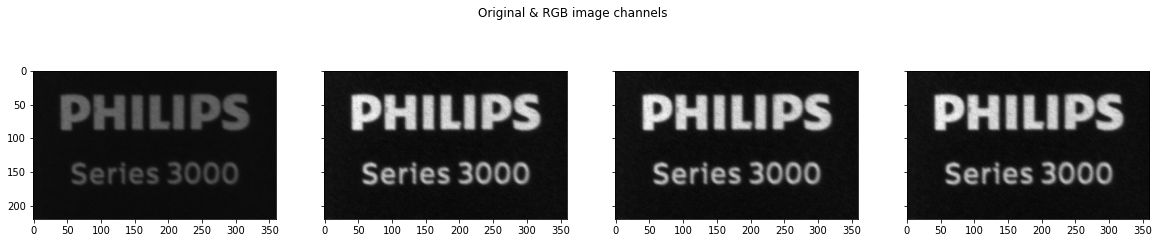

In [237]:
# plotting the original image and the RGB channels  

i, (im1, im2, im3, im4) = plt.subplots(1, 4, sharey=True)
i.set_figwidth(20) 

im1.imshow(image)  #Original image
im2.imshow(image[:, : , 0]) #Red
im3.imshow(image[:, : , 1]) #Green
im4.imshow(image[:, : , 2]) #Blue
i.suptitle('Original & RGB image channels')

## Grayscale conversion

Grayscale is simply converting images from colored to black and white. It is normally used to reduce computation complexity in machine learning algorithms.

Since most pictures don’t need color to be recognized, it is wise to use grayscale, which reduces the number of pixels in an image, thus, reducing the computations required.


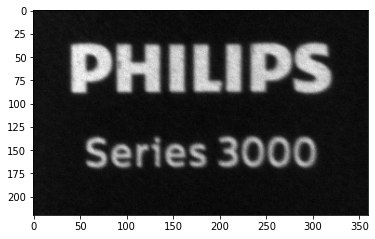

In [238]:
gray_image = skimage.color.rgb2gray(image)
plt.imshow(gray_image, cmap = 'gray')

NB: Converting images to grayscale might not always be practical in solving some problems. A few examples where it would be impractical to use grayscale include: traffic lights, healthcare diagnosis, autonomous vehicles, agriculture, etc. The best way to know whether to use it or not depends on your human visual ability to identify an object without color.

## Normalization
Also referred to as data re-scaling, it is the process of projecting image data pixels (intensity) to a predefined range (usually (0,1) or (-1, 1)). This is commonly used on different data formats, and you want to normalize all of them to apply the same algorithms over them.

Normalization is usually applied to convert an image’s pixel values to a typical or more familiar sense.

Its benefits include:

Fairness across all images - For example, scaling all images to an equal range of [0,1] or [-1,1] allows all images to contribute equally to the total loss rather than when other images have high and low pixels ranges give strong and weak loss, respectively.

Provides a standard learning rate - Since high pixel images require a low learning rate and low pixel images high learning rate, re-scaling helps provide a standard learning rate for all images.

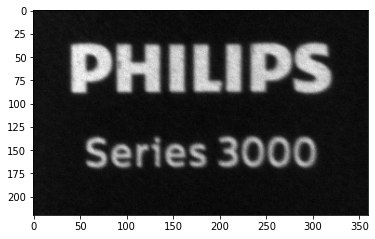

In [239]:
norm_image = (gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))
plt.imshow(norm_image)

## Data augmentation
Data augmentation is the process of making minor alterations to existing data to increase its diversity without collecting new data.

It is a technique used for enlarging a dataset. Standard data augmentation techniques include horizontal & vertical flipping, rotation, cropping, shearing, etc.

Performing data augmentation helps in preventing a neural network from learning irrelevant features. This results in better model performance.

Standard data augmentation techniques include horizontal & vertical flipping, rotation, cropping, shearing, etc.

There are two types of augmentation:

Offline augmentation - Used for small datasets. It is applied in the data preprocessing step. We will be covering this augmentation in this tutorial.

Online augmentation- Used for large datasets. It is normally applied in real-time.

For this tutorial, we shall use Keras’s ImageDataGenerator class to augment our data. This is because it provides a quick and easy way to augment your images.

In addition, it supports augmentation techniques such as flips, rotations, brightness change, etc.

Let’s now look at the most used data augmentation techniques:

### Shifting
This is the process of shifting image pixels horizontally or vertically.

Let’s look at an example below that shifts horizontally:



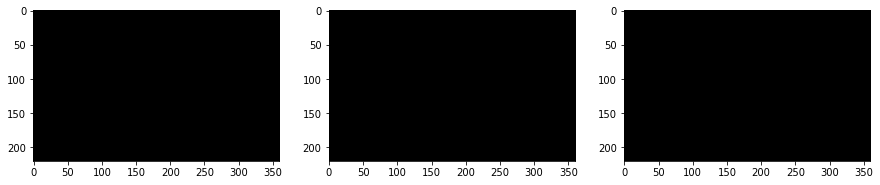

In [243]:
# import libraries

from numpy import expand_dims
# from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

# convert to numpy array
# data = img_to_array(image)
data=image

# expand dimension to one sample
samples = expand_dims(image, 0)

# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=[-200,200])

# create an iterator
it = datagen.flow(samples, batch_size=1)
fig, im = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# generate batch of images
for i in range(3):

    # convert to unsigned integers
    image = next(it)[0].astype('uint8')
 
    # plot image
    im[i].imshow(image) 

## Flipping
This reverses the rows or columns of pixels in either vertical or horizontal cases, respectively.

Let’s do a random flip with both horizontal and vertical flips. From the code above, change the ImageDataGenerator parameters as shown below:

In [244]:
# ImageDataGenerator for flipping
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

-----------------------------------------------------------------------------------------------

In [283]:
# !pip install opencv-python

from keras.applications import resnet
from keras.applications.resnet import preprocess_input, decode_predictions

from keras.preprocessing import image
import keras.backend as K

import numpy as np
import cv2


def do_salience(image, model, label, prefix):
  '''
  Generates the saliency map of a given image.

  Args:
    image (file) -- picture that the model will classify
    model (keras Model) -- your cats and dogs classifier
    label (int) -- ground truth label of the image
    prefix (string) -- prefix to add to the filename of the saliency map
  '''

  # Read the image and convert channel order from BGR to RGB
  # YOUR CODE HERE
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

  # Resize the image to 300 x 300 and normalize pixel values to the range [0, 1]
  # YOUR CODE HERE
  # img = cv2.resize(img, (360, 220)) / 255.0



  # Add an additional dimension (for the batch), and save this in a new variable
  # YOUR CODE HERE
    img = np.expand_dims(img, axis=0)
  


  # Declare the number of classes
  # YOUR CODE HERE
    num_classes=3


  # Define the expected output array by one-hot encoding the label
  # The length of the array is equal to the number of classes
  # YOUR CODE HERE
    expected_output=tf.one_hot([label]*img.shape[0], num_classes)



  # Witin the GradientTape block:
  # Cast the image as a tf.float32
  # Use the tape to watch the float32 image
  # Get the model's prediction by passing in the float32 image
  # Compute an appropriate loss
  # between the expected output and model predictions.
  # you may want to print the predictions to see if the probabilities adds up to 1
  # YOUR CODE HERE
    with tf.GradientTape() as tape:
    inputs = tf.cast(img, tf.float32)
    tape.watch(inputs)
    predictions = model(inputs)
    loss = tf.keras.losses.categorical_crossentropy(
        expected_output, predictions
    )
    print(predictions)



  # get the gradients of the loss with respect to the model's input image
  # YOUR CODE HERE
    gradients = tape.gradient(loss, inputs)

    
  # generate the grayscale tensor
  # YOUR CODE HERE
    grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)


  # normalize the pixel values to be in the range [0, 255].
  # the max value in the grayscale tensor will be pushed to 255.
  # the min value will be pushed to 0.
  # Use the formula: 255 * (x - min) / (max - min)
  # Use tf.reduce_max, tf.reduce_min
  # Cast the tensor as a tf.uint8
  # YOUR CODE HERE
  normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

    
  # Remove dimensions that are size 1
  # YOUR CODE HERE
    normalized_tensor=tf.squeeze(normalized_tensor)
    heatmap = normalized_tensor.numpy()
    heatmap = heatmap

  # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img[0].shape[1], img[0].shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
    alpha=0.4
    superimposed_img = jet_heatmap * alpha + img[0]*255
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
  # plot 

    f, axarr = plt.subplots(1,2, figsize=(12, 12))

    axarr[0].imshow(img[0])
    axarr[1].imshow(superimposed_img, cmap='gray')

IndentationError: unexpected indent (<ipython-input-283-3bee1da17e83>, line 26)

tf.Tensor([[0. 1. 0.]], shape=(1, 3), dtype=float32)
tf.Tensor([[0. 1. 0.]], shape=(1, 3), dtype=float32)
tf.Tensor([[0. 1. 0.]], shape=(1, 3), dtype=float32)


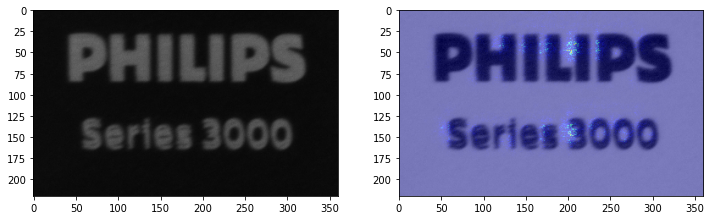

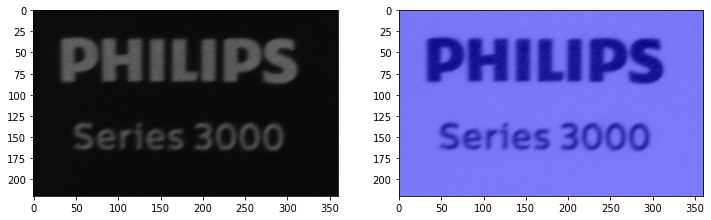

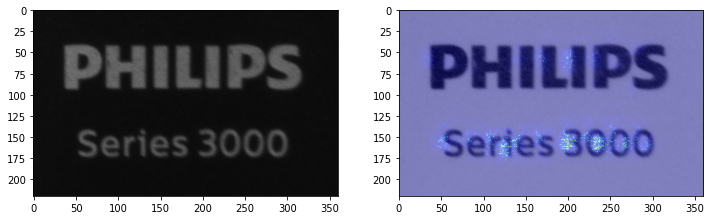

In [203]:
for i, currentCls in enumerate(all_classes):
  
    src = src_dir + '/' + currentCls

    allFileNames = os.listdir(src)
    image_file = random.choice(allFileNames)
    
    do_salience(src+'/'+ image_file, model, i, "salient")

In [191]:
for layer in model.get_layer('resnet50').layers:
    print(layer.name)

input_5
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [192]:
for layer in model.layers:
    print(layer.name)

resnet50
flatten_5
dense_5


## CamGrad

In [193]:
import scipy as sp


cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].get_output_at(0),model.layers[-1].get_output_at(0)))

features,results = cam_model.predict(x_test)

# shape of the features
print("features shape: ", features.shape)
print("results shape", results.shape)

last_dense_layer = model.layers[-1]

# get the weights list.  index 0 contains the weights, index 1 contains the biases
gap_weights_l = last_dense_layer.get_weights()

print("gap_weights_l index 0 contains weights ", gap_weights_l[0].shape)
print("gap_weights_l index 1 contains biases ", gap_weights_l[1].shape)

# shows the number of features per class, and the total number of classes
# Store the weights
gap_weights = gap_weights_l[0]

print(f"There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes.")

# Get the features for the image at index 0
idx = -1
image_index = idx
features_for_img = features[idx,:,:,:]

print(f"The features for image index {idx} has shape (height, width, num of feature channels) : ", features_for_img.shape)

# Select the weights that are used for a specific class (0...9)
class_id = 0
# take the dot product between the scaled image features and the weights for 
gap_weights_for_one_class = gap_weights[:,class_id]
gap_weights_for_one_class = gap_weights_for_one_class.reshape((7,12,2048))

print("gap_weights_for_one_class has shape ", gap_weights_for_one_class.shape)
# take the dot product between the scaled features and the weights for one class
cam = np.multiply(features_for_img, gap_weights_for_one_class)
cam = sp.ndimage.zoom(cam, (220/7, 360/12, 1), order=2)
cam = np.sum(cam, axis = 2)

print("class activation map shape ", cam.shape)

23/23 [==============================] - 23s 964ms/step
features shape:  (712, 7, 12, 2048)
results shape (712, 3)
gap_weights_l index 0 contains weights  (172032, 3)
gap_weights_l index 1 contains biases  (3,)
There are 172032 feature weights and 3 classes.
The features for image index -1 has shape (height, width, num of feature channels) :  (7, 12, 2048)
gap_weights_for_one_class has shape  (7, 12, 2048)
class activation map shape  (220, 360)


1


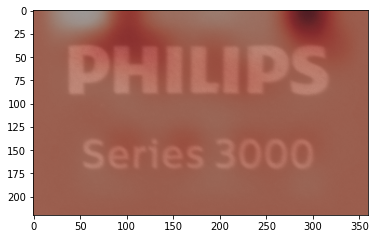

In [194]:
prediction = np.argmax(results[image_index])

# X_test_in = test_ds.unbatch()
# X_test = list(X_test_in.map(lambda x, y: x))

print(prediction)
# show the upsampled image
plt.imshow(x_test[image_index], alpha=0.8)
  
# strongly classified (95% probability) images will be in green, else red
if results[image_index][prediction]>0.95:
    cmap_str = 'Greens'
else:
    cmap_str = 'Reds'

# overlay the cam output
plt.imshow(cam, cmap=cmap_str, alpha=0.5)

# display the image
plt.show()

In [195]:
def show_cam(image_index):
  '''displays the class activation map of a particular image'''

  # takes the features of the chosen image
  features_for_img = features[image_index,:,:,:]

  # get the class with the highest output probability
 

  # get the gap weights at the predicted class
  class_activation_weights = gap_weights[:,prediction]

  # upsample the features to the image's original size (28 x 28)
  class_activation_features = sp.ndimage.zoom(features_for_img, (28/3, 28/3, 1), order=2)

  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)
  
  print('Predicted Class = ' +str(prediction)+ ', Probability = ' + str(results[image_index][prediction]))
  

In [196]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [197]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer('resnet50').get_output_at(0), model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [390]:
from IPython.display import Image, display

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))



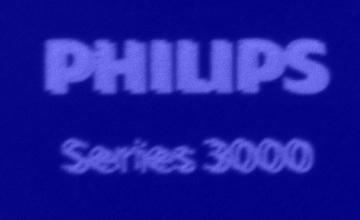

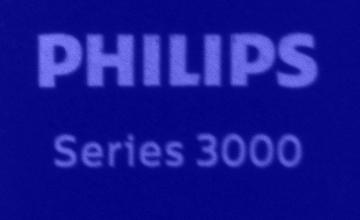

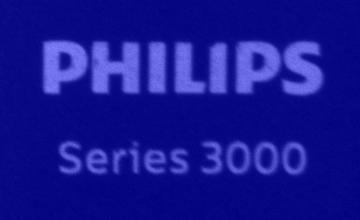

In [392]:
for i, currentCls in enumerate(all_classes):
  
    src = src_dir + '/' + currentCls

    allFileNames = os.listdir(src)
    image_file = random.choice(allFileNames)
    
    img_array = get_img_array(src+'/'+ image_file, size = (220,360,3))
    
    heatmap = make_gradcam_heatmap(img_array, model, 'conv5_block2_2_relu')
    save_and_display_gradcam(src+'/'+ image_file, heatmap)